In [1]:
import numpy as np
import pandas as pd
import gensim
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
data = pd.read_pickle('../TransformedFullData.pkl')

data1 = pd.read_csv("../arzta_daten_anonym1.csv", sep=';')
data2 = pd.read_csv("../arzta_daten_anonym2.csv", sep=';')
data3 = pd.read_csv("../arzta_daten_anonym3.csv", sep=';')
data4 = pd.read_csv("../arzta_daten_anonym4.csv", sep=';')
DATA = pd.concat([data1, data2, data3, data4], axis=0).reset_index(drop=True)

In [16]:
%%time
## transfrom str type to float type
columns_comma = ['RECHNUNGSBETRAG', 'FAKTOR', 'BETRAG', 'ALTER', 'KORREKTUR'] 
DATA[columns_comma] = DATA[columns_comma].apply(lambda x: x.str.replace(',', '.'))
for column in columns_comma:
    DATA[column] = pd.to_numeric(DATA[column], downcast='float')

CPU times: user 13.8 s, sys: 1.68 s, total: 15.5 s
Wall time: 15.5 s


In [17]:
%%time
## construct target column
target = DATA.groupby(['ID'])['KORREKTUR'].apply(lambda dt: int(np.sign(dt).values[0])).to_frame(name='target')
DATA = DATA.merge(target, on='ID', how='inner')

CPU times: user 44.9 s, sys: 836 ms, total: 45.8 s
Wall time: 45.8 s


In [18]:
## DATA must be sorted by Id
current_id = ''
indices = []

for i, Id in enumerate(DATA.ID):
    if Id != current_id:
        if i > 0: 
            indices.append(current_index)
        current_id = Id
        current_index = [i]
    else:
        current_index.append(i)
        
indices.append(current_index)

In [19]:
%%time

sentences = []

start = time()
ids = DATA.ID.unique()
for i, Id in enumerate(ids):    
    sentences.append(list(DATA.iloc[indices[i]]['NUMMER'].dropna()))
    
    if i % 3000 == 0: 
        print(i, 'Done', np.round(i / len(ids) * 100, 2) , '% time:', time() - start)    

0 Done 0.0 % time: 1.3611035346984863
3000 Done 0.79 % time: 3.738217353820801
6000 Done 1.57 % time: 6.102413654327393
9000 Done 2.36 % time: 8.473212718963623
12000 Done 3.15 % time: 10.837743520736694
15000 Done 3.94 % time: 13.207981586456299
18000 Done 4.72 % time: 15.568707466125488
21000 Done 5.51 % time: 17.92839789390564
24000 Done 6.3 % time: 20.30109715461731
27000 Done 7.09 % time: 22.697383642196655
30000 Done 7.87 % time: 25.096680641174316
33000 Done 8.66 % time: 27.485714435577393
36000 Done 9.45 % time: 29.854055166244507
39000 Done 10.24 % time: 32.50852727890015
42000 Done 11.02 % time: 34.930681228637695
45000 Done 11.81 % time: 37.348920583724976
48000 Done 12.6 % time: 39.78196167945862
51000 Done 13.39 % time: 42.18995499610901
54000 Done 14.17 % time: 44.57182717323303
57000 Done 14.96 % time: 46.95595955848694
60000 Done 15.75 % time: 49.34984064102173
63000 Done 16.53 % time: 51.752201557159424
66000 Done 17.32 % time: 54.15963673591614
69000 Done 18.11 % time

In [20]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
# import nltk
# nltk.download('punkt')

In [21]:
%%time
sentences = [' '.join(sent) for sent in sentences]
tagged_data = [TaggedDocument(words=word_tokenize(sent.lower()), tags=[str(i)]) for i, sent in enumerate(sentences)]

CPU times: user 38.4 s, sys: 420 ms, total: 38.9 s
Wall time: 38.9 s


In [9]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [151]:
%%time
max_epochs = 20
vec_size = 100

model = Doc2Vec(vector_size=vec_size,
                min_count=0, dm=0, alpha=0.025)

sample_size = len(tagged_data)

model.build_vocab(tagged_data[:sample_size])
frauds = set(data.iloc[:sample_size][data.target==1].index)

CPU times: user 10.8 s, sys: 0 ns, total: 10.8 s
Wall time: 10.8 s


In [160]:
start = time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch), ', time = ', time()-start, ', alpha = ', model.alpha)
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=5)    
    # decrease the learning rate
    model.alpha -= 0.001
    ## fix the learning rate, no decay
    # model.min_alpha = model.alpha
print('time = ', time()-start)

iteration 0 , time =  8.058547973632812e-05 , alpha =  0.004999999999999986
iteration 1 , time =  57.61266899108887 , alpha =  0.003999999999999986
iteration 2 , time =  105.8925051689148 , alpha =  0.002999999999999986
iteration 3 , time =  157.04553294181824 , alpha =  0.001999999999999986
iteration 4 , time =  218.3897032737732 , alpha =  0.0009999999999999861
iteration 5 , time =  279.46326756477356 , alpha =  -1.3877787807814457e-17
iteration 6 , time =  339.7318994998932 , alpha =  -0.001000000000000014
iteration 7 , time =  400.16959857940674 , alpha =  -0.002000000000000014
iteration 8 , time =  460.5867338180542 , alpha =  -0.003000000000000014
iteration 9 , time =  520.8374328613281 , alpha =  -0.004000000000000014
iteration 10 , time =  581.4970059394836 , alpha =  -0.005000000000000014
iteration 11 , time =  641.7023522853851 , alpha =  -0.006000000000000014
iteration 12 , time =  702.2830729484558 , alpha =  -0.007000000000000014
iteration 13 , time =  763.2725524902344 , 

KeyboardInterrupt: 

In [161]:
%%time
vectors = get_vectors(model, sentences[:sample_size])
loss = calc_similarity(model, vectors, frauds, topn=10)
print(loss)

/home/rasul/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


3.294900998773436
CPU times: user 8min 48s, sys: 10min 19s, total: 19min 8s
Wall time: 2min 28s


In [128]:
def get_vectors(model, sentences):
    vectors = []
    for i, s in enumerate(sentences):
        tokenized_vector = word_tokenize(s.lower())
        infered_vector = model.infer_vector(tokenized_vector, steps=6)
        vectors.append(infered_vector)

    return np.array(vectors)

def calc_similarity(model, vectors, frauds, topn=10):
    trace = []
    
    for index in list(frauds):
        similar_vectors = model.docvecs.most_similar([vectors[index]], topn=topn)
        vectors_id = set([np.int64(vector[0]) for vector in similar_vectors])
        
        trace.append(len(vectors_id & frauds))
    
    return np.mean(trace)

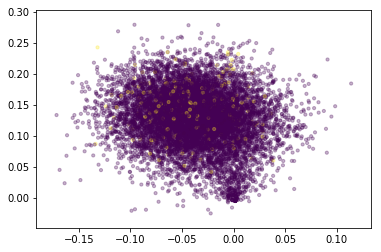

In [170]:
N = 10000
plt.scatter(vectors[:N, 99], vectors[:N, 98], c=data.target[:N], s=10, alpha=0.3)

In [35]:
DATA.shape, data.shape, np.array(vectors).shape

((3275027, 16), (381013, 2379), (381013, 3))

In [154]:
d = pd.concat([data.drop(columns=DATA.NUMMER.dropna().unique()), 
               pd.DataFrame(vectors, columns=['NUMMER' + str(i) for i in range(len(vectors[0]))])], axis=1)
d.to_pickle('../TransformedFullData_embedded_v1.pkl')

In [155]:
d2 = pd.concat([data, pd.DataFrame(vectors, columns=['NUMMER' + str(i) for i in range(len(vectors[0]))])], axis=1)
d2.to_pickle('../TransformedFullData_embedded_v2.pkl')

In [158]:
d2.shape, d2.dropna().shape

((381013, 2479), (381013, 2479))